# Week 4 Kaggle Project

## BBC News Topics by Article

In [2]:
import numpy as np
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
import string
import seaborn as sns
from sklearn.decomposition import NMF
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from gensim.utils import simple_preprocess
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

# Import Training and Testing Data

- df and df_test are for NMF unsupervised
- df_rf and df_rf_test are for supervised randomforest classification comparison

In [3]:
# Establish Training and Testing datasets
df = pd.read_csv('BBC News Train.csv')
df_test = pd.read_csv('BBC News Test.csv')

df_rf = pd.read_csv('BBC News Train.csv')
df_test_rf = pd.read_csv('BBC News Test.csv')


# Inspect the Data

- Find Shape
- Count na, nan
- Check data types
- Inspect unique Values
- Remove duplicate texts

In [4]:
print("+ Shape is: ", df.shape)
 
print("+ Number of na values: ", df.isna().sum())
 
print("+ Data types: ", df.dtypes)
 
print("+ Unique value counts: ", df.nunique())
 
print("+ Number of unique categories: ", df.Category.unique())
 
print("+ Text duplicates in the data: " ,df.duplicated(subset = ['Text']).sum())

+ Shape is:  (1490, 3)
+ Number of na values:  ArticleId    0
Text         0
Category     0
dtype: int64
+ Data types:  ArticleId     int64
Text         object
Category     object
dtype: object
+ Unique value counts:  ArticleId    1490
Text         1440
Category        5
dtype: int64
+ Number of unique categories:  ['business' 'tech' 'politics' 'sport' 'entertainment']
+ Text duplicates in the data:  50


### EDA Discussion

I found that 50 texts were duplicated in the document. I will remove the duplicate text before applying any algorithms for classification/prediction. 5 distinct categories were found and 0 na/nan values were observed during EDA.

In [5]:
# Remove duplicate texts and ensure no na exists
df = df.drop_duplicates(subset = ['Text'])
df.shape
df.dropna(subset = ['Text'], inplace = True)

df_test = df.drop_duplicates(subset = ['Text'])
df_test.shape
df_test.dropna(subset = ['Text'], inplace = True)

In [6]:
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


## Word Count Visualization and LNP Processes

Establish lemmatizer and stopwords for removal using NLTK. Define a word counting fuctions and create histogram of word counts. This step will assist with hyperparameter tuning in future steps


In [7]:
stopwords = nltk.corpus.stopwords.words('english')
wnl = nltk.WordNetLemmatizer()

In [8]:
def count_words(text):
    return len(str(text).split(' '))
   
df['w_count'] = df['Text'].apply(count_words)

Text(0.5, 1.0, 'Word Count Distribution')

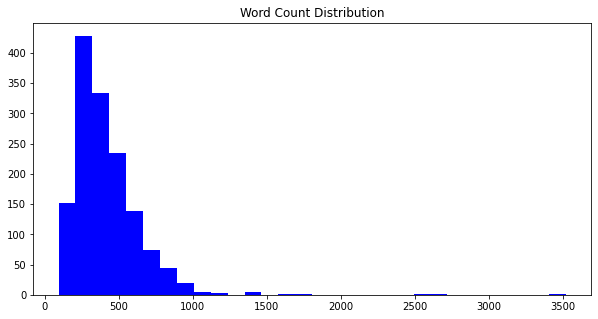

In [9]:
fig = plt.figure(figsize = (10,5))
 
plt.hist(df['w_count'], bins=30, color = "blue")
 
plt.title('Word Count Distribution')

## Clean documents and find the most frequent words in the documents

Text cleaning removes any punctuation and stopwords (words that will not be significant during analysis). I will create a list of words per text that will be most meaningful. Lemmmatization will provide a list of root words and will remove features such as tense and plurality.

In [10]:
df.w_count.describe()

# Text cleaning fuction
# remove puctionation, stopwords
def cleantext(text):
    text = "".join([word for word in text if word not in string.punctuation])
    words = re.split('\W+', text)
    text = [wnl.lemmatize(word) for word in words if word not in stopwords]
    return text

# Prepare  texts for training and testing sets
df['proc_words'] = df.Text.apply(cleantext)
df['proc_words1'] = df.Text.apply(simple_preprocess)

df_test['proc_words'] = df_test.Text.apply(cleantext)
df_test['proc_words1'] = df_test.Text.apply(simple_preprocess)

In [11]:
p_w = df.proc_words.to_numpy().flatten()

# Custom word cound funtion to find top occuring words
def u_word_count(df):
    w_dict = {}
    for r in df.proc_words:
        for word in r:
            if word not in w_dict.keys():
                w_dict[word] = 1
            w_dict[word] +=1
    return w_dict
 
u_word_counts = u_word_count(df)
w_df = pd.DataFrame.from_dict(u_word_counts, orient = 'index', columns = ['frequency']).reset_index()
 
tw_df = w_df.sort_values(by = ['frequency'], ascending = False)[0:20]

<AxesSubplot:xlabel='index', ylabel='frequency'>

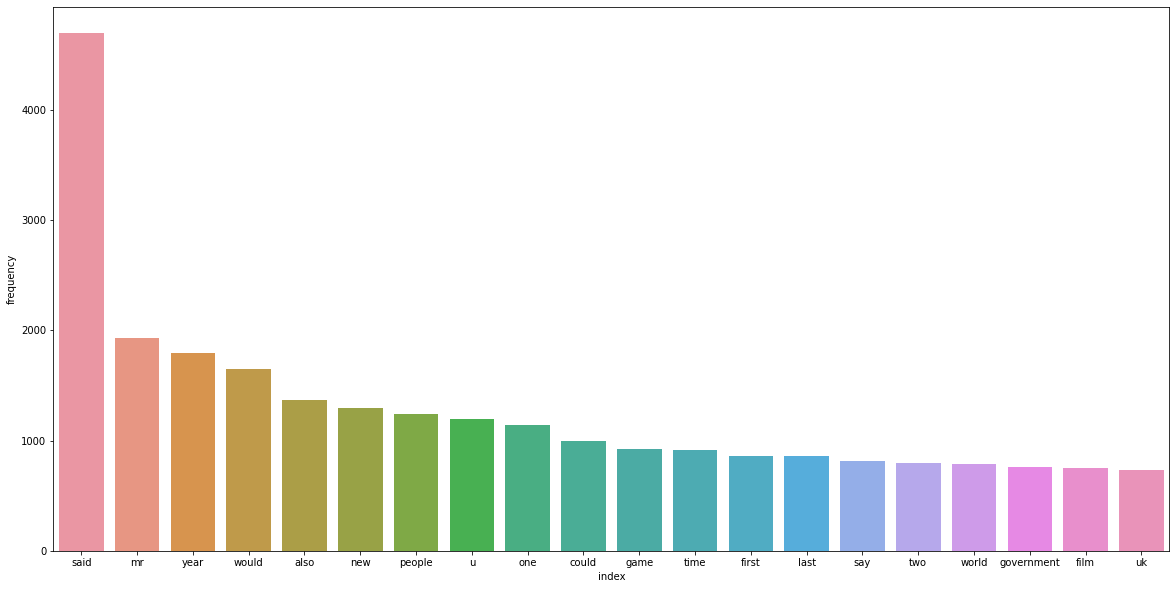

In [12]:
plt.figure(figsize = (20,10))
sns.barplot(x = 'index', y = 'frequency', data = tw_df)

## Create Bag of Words and Vectorized the documents

Use gensim to create a bag of words. The dictionary will assign words to their meaning via unique integer assignment. For each text there will be a "bag of words" and their meanings to apply to topical analysis. TFIDF will transform the bag of words into a vector form for use within the algorithms. 

In [13]:
docs = df['proc_words']
docs_test = df_test.proc_words
 
dictionary = Dictionary(docs)
dictionary_test = Dictionary(docs_test)

corp = [dictionary.doc2bow(doc, allow_update = True) for doc in docs]
corp_test = [dictionary.doc2bow(doc, allow_update = True) for doc in docs_test]

By using max_df I can help decide word importance by elimating words that appear in 80% of documents as I have done below. Also, I can manage words that appear a minimum number of times, such as 6, per text. Max_features allows me to reduce the number of features (words) that are used to train the algorithm

In [77]:
tfidf = TfidfVectorizer(max_df = 0.8, min_df = 6, max_features = 2500, preprocessor = ' '.join)
 
tf = tfidf.fit_transform(docs)
tf_test = tfidf.transform(docs_test)



## NonNegative Matrix Factorization

Use sklearn.decomposition to access the NMF() method. The initialization of the method with 'nndsvd' was chose due to the sparse nature of the data. Since it is known that there are 5 categories, n_components was set to 5. Alpha helps control the regularization of the data.

### Training Data

In [78]:
nmf = NMF(
    n_components=5,
    init='nndsvd',
    alpha = .25,
    random_state = 1029,
    max_iter = 1000
).fit(tf)

In [79]:
H = nmf.transform(tf)
W = nmf.components_

In [80]:
pubs = df.index.tolist()

topic = H.argmax(axis = 1)

preds = pd.DataFrame({'articles': pubs, 'preds': topic})

In [81]:
A = tf 
W = nmf.components_
H = nmf.transform(A)

print('A = {} x {}'.format(A.shape[0], A.shape[1]))
print('W = {} x {}'.format(W.shape[0], W.shape[1]))
print('H = {} x {}'.format(H.shape[0], H.shape[1]))

A = 1440 x 2500
W = 5 x 2500
H = 1440 x 5


## Pick the label sequence by accuracy

In [82]:
import itertools

def pick_labels(topics, t_topics):
    max_acc, max_ind = 0, 0
    unique_classes = df.Category.unique()
    permutes = list(itertools.permutations(unique_classes))
    yp = pd.Series(preds.preds)
    for i in range(len(permutes)):
        acc = 0
        ypd = yp.replace(to_replace = [0,1,2,3,4], value = list(permutes[i]))
        acc = accuracy_score(df.Category, ypd)
        if acc > max_acc:
            max_acc = acc
            max_ind = permutes[i]
            ypd = yp

    return max_ind, max_acc

In [83]:
pick_labels(preds, df)

(('business', 'politics', 'entertainment', 'sport', 'tech'),
 0.9118055555555555)

## Measure the residual

The mean of the squared error for the predictions is under 1 (.974)

In [85]:
r = np.zeros(A.shape[0])

for row in range(A.shape[0]):
    r[row] = np.linalg.norm(A[row, :] - H[row, :].dot(W))

sum_sqrt_res = round(np.mean(np.sqrt(r)), 3)
'Mean of the squared residuals is {}'.format(sum_sqrt_res)


'Mean of the squared residuals is 0.974'

## Test accuracy of unsupervised algorithm on test data

In [59]:
t_A = tf_test
t_H = nmf.transform(tf_test)
t_W = nmf.components_

In [60]:
t_pubs = df_test.index.tolist()

t_topic = t_H.argmax(axis = 1)

test_preds = pd.DataFrame({'articles': t_pubs, 'preds': t_topic})

In [61]:
def pick_labels_test(topics, t_topics):
    max_acc, max_ind = 0, 0
    unique_classes = df_test.Category.unique()
    permutes = list(itertools.permutations(unique_classes))
    yp = pd.Series(test_preds.preds)
    for i in range(len(permutes)):
        acc = 0
        ypd = yp.replace(to_replace = [0,1,2,3,4], value = list(permutes[i]))
        acc = accuracy_score(df_test.Category, ypd)
        if acc > max_acc:
            max_acc = acc
            max_ind = permutes[i]
            ypd = yp

    return max_ind, max_acc

In [62]:
pick_labels_test(test_preds, df_test)

(('business', 'politics', 'entertainment', 'sport', 'tech'),
 0.9104166666666667)

In [63]:
t_r = np.zeros(t_A.shape[0])

for row in range(t_A.shape[0]):
    t_r[row] = np.linalg.norm(t_A[row, :] - t_H[row, :].dot(t_W))

sum_sqrt_res = round(np.mean(np.sqrt(r)), 3)
'Sum of the squared residuals is {}'.format(sum_sqrt_res)

'Sum of the squared residuals is 0.973'

## Supervised Learning Comparison
### Random Forest Classifier

The supervised approach yielded better results on average than the unsupervised, but not by much. The best model under the supervized learning approach returned a max accuracy of 99.65% (20% test set) versus the highest unsupervised approach at 92%

In [98]:
df_rf = pd.DataFrame(A.toarray(), columns = tfidf.get_feature_names())
df_rf_y = df.Category.astype('category')

rf_Xtrain, rf_Xtest, rf_ytrain, rf_ytest = train_test_split(df_rf, df_rf_y, test_size = .2)

model = RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits = 9, n_repeats = 3, random_state = 1)
n_scores = cross_val_score(model, rf_Xtrain, rf_ytrain, scoring = 'accuracy', cv = cv, n_jobs = 1, error_score = 'raise')

In [99]:
n_scores

array([0.984375 , 0.9375   , 0.9296875, 0.9453125, 0.90625  , 0.953125 ,
       0.9296875, 0.96875  , 0.96875  , 0.9609375, 0.90625  , 0.9453125,
       0.9296875, 0.96875  , 0.921875 , 0.9453125, 0.96875  , 0.953125 ,
       0.984375 , 0.9296875, 0.9609375, 0.9453125, 0.9375   , 0.953125 ,
       0.953125 , 0.9296875, 0.984375 ])

In [100]:
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.948 (0.021)


In [101]:
n_estimators = [int(x) for x in np.linspace(start = 25, stop = 1000, num = 25)]
max_features = ['sqrt']
max_depth = [x for x in range(1,10)] + [None]
min_sample_split = [2,5,10]
min_sample_leaf = [1,2,4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators, 
               'max_features': max_features, 
               'max_depth': max_depth, 
              'min_samples_split': min_sample_split,
              'min_samples_leaf': min_sample_leaf,
              'bootstrap': bootstrap}

In [102]:
ran_mod = RandomForestClassifier()

rf_search = RandomizedSearchCV(estimator = ran_mod, param_distributions = random_grid, cv = cv, random_state = 42)

rf_search.fit(df_rf, df_rf_y)

KeyboardInterrupt: 

In [372]:
rf_search.best_params_

{'n_estimators': 65,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [96]:
final_mod = RandomForestClassifier(n_estimators = 65, min_samples_split = 2, min_samples_leaf = 4, max_features = 'sqrt',
                                  max_depth = None, bootstrap = False).fit(df_rf, df_rf_y)

In [97]:
final_mod.score(rf_Xtest, rf_ytest)

0.9965277777777778

## Movie Rating Dataset

The nmf did not work nearly as well on the Movie Rating data. It was quite slow and yielded an accuracy of 39% and an rsme over 1. With the BBC News data set the number of groups was known whereas with the Mr data the number of groups among users and movies is not known. Furthermore, similarity among groups was not a natural predictor of individual ratings for individual movies. A less generalized approach works better to find strong relationships in preference and to make better predictions.

In [25]:
Mr = pd.read_csv('Mr.csv')
Mr.head()
Mr = Mr.sample(frac = .30, random_state = 1)


In [98]:
Mr_df = Mr.pivot(index = 'Uid', columns = 'mID', values = 'rating' )
Mr_m = Mr_df.reset_index().to_numpy()
Mr_m = np.where(np.isnan(Mr_m), 0, Mr_m)

In [99]:
nmf_mr1 = NMF(
    n_components = 7,
    init='nndsvd',
    alpha = .25,
    random_state = 1029,
    max_iter = 500
).fit(Mr_m)

c:\users\trahajo\appdata\local\programs\python\python38\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [100]:
nmf_mr1.components_

array([[5.20623417e+02, 5.49155853e-03, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.86157231e-01, 0.00000000e+00, 6.14607463e-01, ...,
        0.00000000e+00, 0.00000000e+00, 9.18906711e-02],
       [4.86195814e-01, 0.00000000e+00, 0.00000000e+00, ...,
        9.78535310e-02, 4.23316494e-02, 4.40099834e-02],
       ...,
       [3.67116307e-01, 9.54958348e-01, 2.98785749e-01, ...,
        0.00000000e+00, 0.00000000e+00, 1.32599683e-03],
       [1.83623086e-02, 2.07864017e+00, 4.46011086e-01, ...,
        0.00000000e+00, 0.00000000e+00, 2.99463095e-02],
       [1.82675230e-01, 4.89379407e-01, 0.00000000e+00, ...,
        2.95744151e-02, 0.00000000e+00, 1.40448248e-01]])

In [101]:
mr_A = Mr_m
mr_H = nmf_mr1.transform(mr_A)
mr_W = nmf_mr1.components_

In [103]:
m = Mr_df.index.tolist()

rating_pred = mr_H.argmax(axis = 1)

preds_mr = pd.DataFrame({'Uid': m, 'group': rating_pred})

In [104]:
Mr_groups = Mr.merge(preds_mr, on = 'Uid', how = 'left')

In [125]:
def add_col(df):
    p = []
    for r in range(len(df)):
        p.append(round(Mr_groups.loc[(Mr_groups['mID'] == Mr_groups.iloc[r].mID) & (Mr_groups['group'] == Mr_groups.iloc[r].group),
                             ['rating']].mean())+1)
    return p
    



In [129]:
Mr_groups['Pred'] = add_col(Mr_groups)

,Uid,mID,rating,group,Pred
0,3809,2924,4,0,4
1,1389,1957,4,0,4
2,4510,1479,2,0,3
3,1017,3840,3,0,3
4,1546,1422,3,0,3
...,...,...,...,...,...
300058,75,2087,4,5,4
300059,1470,3452,3,0,3
300060,4000,32,4,0,4
300061,1162,1262,3,0,4


## Movie Rating Accuracy Score and RMSE

In [132]:
accuracy_score(Mr_groups.rating, Mr_groups.Pred)

0.3907812692667873

In [134]:
np.sqrt(((Mr_groups.rating - Mr_groups.Pred)**2).mean())

1.0008860879298507